In [ ]:
!pip install yfinance numpy pandas matplotlib scipy scikit-learn statsmodels --quiet

[*********************100%***********************]  1 of 1 completed


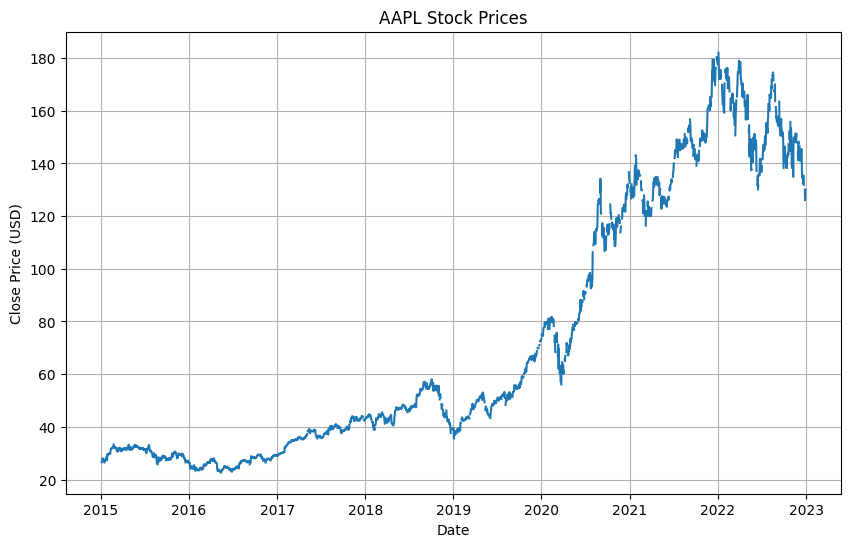

Mean Absolute Error (MAE): 25.72
Root Mean Squared Error (RMSE): 28.94


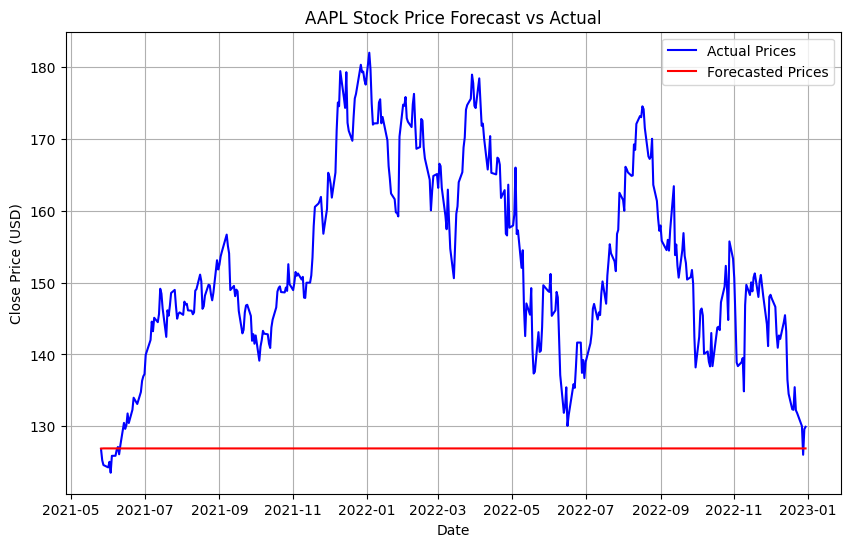

[*********************100%***********************]  4 of 4 completed


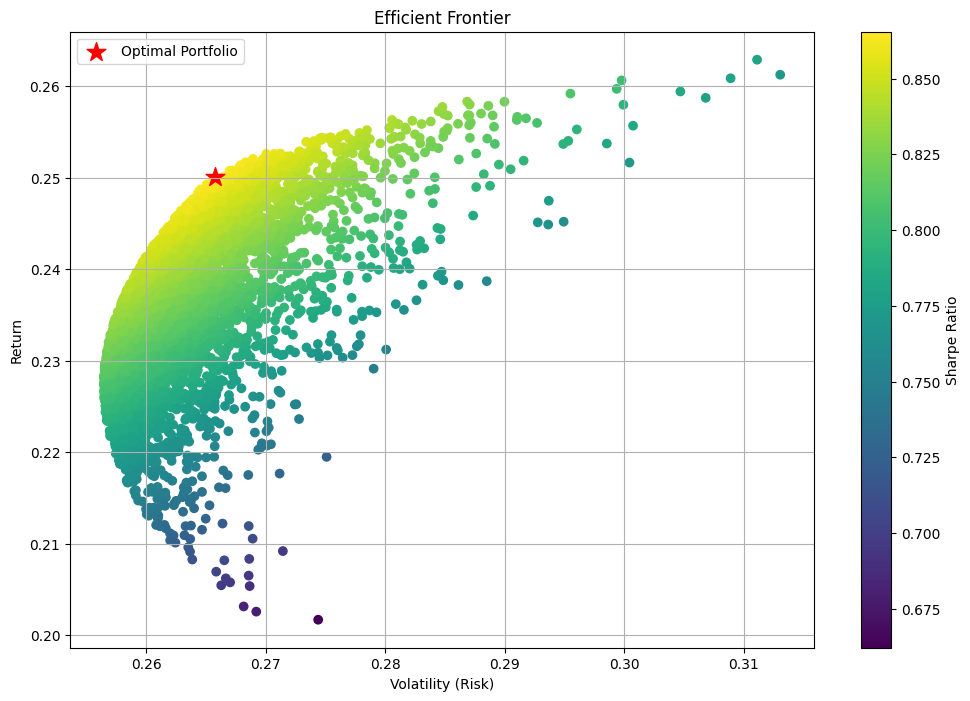

Optimal Portfolio Allocation:
  Ticker        Weight
0   AAPL  2.753179e-01
1   MSFT  3.011207e-01
2   GOOG  1.958805e-17
3   AMZN  4.235614e-01
Sharpe Ratio: 0.8658


In [1]:

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# -----------------------------
# ARIMA FORECASTING SECTION
# -----------------------------

symbol = 'AAPL'
start_date = '2015-01-01'
end_date = '2023-01-01'

data = yf.download(symbol, start=start_date, end=end_date,auto_adjust=False)
stock_prices = data['Close']
stock_prices.index = pd.to_datetime(stock_prices.index)
stock_prices = stock_prices.asfreq('D')

plt.figure(figsize=(10, 6))
plt.plot(stock_prices)
plt.title(f'{symbol} Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.show()

train_size = int(len(stock_prices) * 0.8)
train, test = stock_prices[:train_size], stock_prices[train_size:]
test = test.dropna()

model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

forecast = model_fit.forecast(steps=len(test))
forecast = np.nan_to_num(forecast)

mae = mean_absolute_error(test, forecast)
rmse = sqrt(mean_squared_error(test, forecast))
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual Prices', color='blue')
plt.plot(test.index, forecast, label='Forecasted Prices', color='red')
plt.title(f'{symbol} Stock Price Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# PORTFOLIO OPTIMIZATION SECTION
# -----------------------------
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN']
data = yf.download(tickers, start=start_date, end=end_date,auto_adjust=False)['Close']

daily_returns = data.pct_change().dropna()
annual_returns = daily_returns.mean() * 252
annual_volatility = daily_returns.std() * np.sqrt(252)

risk_free_rate = 0.02


cov_matrix = daily_returns.cov() * 252

def sharpe_ratio(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return (portfolio_return - risk_free_rate) / portfolio_volatility

def negative_sharpe(weights):
    return -sharpe_ratio(weights, annual_returns, cov_matrix)

num_assets = len(tickers)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))
initial_weights = np.ones(num_assets) / num_assets

result = minimize(negative_sharpe, initial_weights, bounds=bounds, constraints=constraints)
optimal_weights = result.x

def portfolio_performance(weights, returns, cov_matrix):
    port_return = np.dot(weights, returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_volatility

num_portfolios = 5000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    weights_record.append(weights)
    ret, vol = portfolio_performance(weights, annual_returns, cov_matrix)
    results[0, i] = vol
    results[1, i] = ret
    results[2, i] = (ret - risk_free_rate) / vol

opt_return, opt_volatility = portfolio_performance(optimal_weights, annual_returns, cov_matrix)
plt.figure(figsize=(12, 8))
plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(opt_volatility, opt_return, color='red', label='Optimal Portfolio', marker='*', s=200)
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.legend()
plt.grid()
plt.show()

optimal_portfolio = pd.DataFrame({
    'Ticker': tickers,
    'Weight': optimal_weights
})
print("Optimal Portfolio Allocation:")
print(optimal_portfolio)

portfolio_return = np.dot(optimal_weights, annual_returns)
portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
final_sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
print(f"Sharpe Ratio: {final_sharpe_ratio:.4f}")
